# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [2]:
from keras.datasets import mnist
import itertools

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

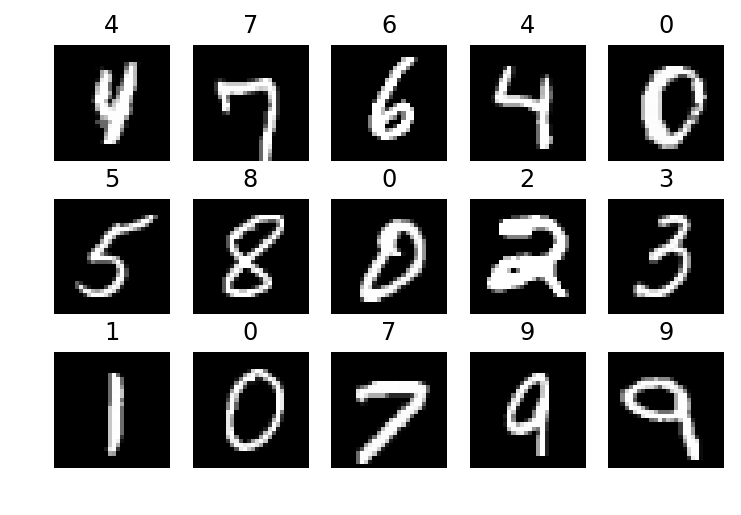

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # TODO: 随机取1~5个数字，并拼接成新的图片
    for i in range(X_len):
        amount = random.randint(1, n_len)
        for j in range(amount):
            index = random.randint(0, X_len-1)
            digit_series_ind = y[index]
            y_gen[j][i][digit_series_ind] = 1            
            X_gen[i][:, width*j:width*(j+1)] = X[index].reshape((height, width, 1))
        for j in range(amount, n_len):
            y_gen[j][i][10] = 1
    y_gen = np.array(y_gen)
    return X_gen, y_gen

X_raw_train, X_raw_valid, y_raw_train, y_raw_valid = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_train, y_train = generate_dataset(X_raw_train, y_raw_train)
X_valid, y_valid = generate_dataset(X_raw_valid, y_raw_valid)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)

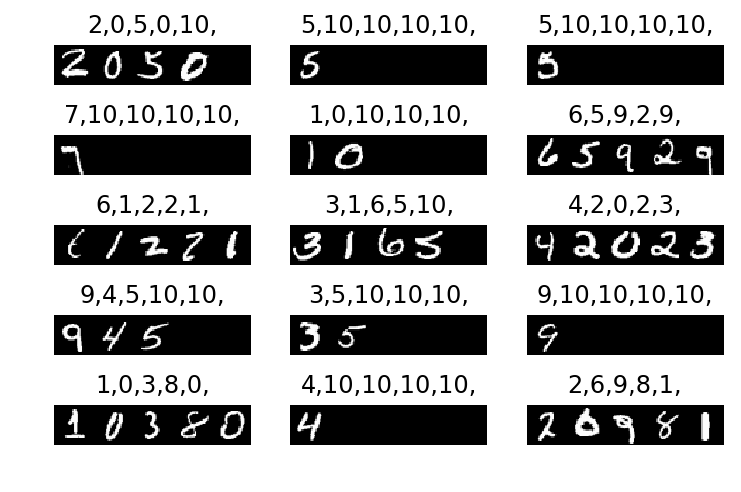

In [5]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

## 加工数据集

构建字符集，并定义转换函数

In [6]:
letters = [str(i) for i in range(10)]
letters.append("#")

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

## 构建 data generator

创建一个DataGenerator类，完成数据的batch的产生

In [7]:
from __future__ import absolute_import
from keras.utils import * 
import random

class DataGenerator():
    """
    """
    def __init__(self, data_source_x, data_source_y):
        self.data_source_x = data_source_x
        self.data_amount = data_source_y.shape[1]
        self.transform_data_y = np.ones([self.data_amount, n_len])
        self.label_length = np.zeros((self.data_amount, 1))
        for i in range(self.data_amount):
            str_num = ""
            curr_len = 0
            for j in range(5):
                ch = np.argmax(data_source_y[j][i])
                if ch == 10:
                    str_num += "#"
                    pass
                else:
                    curr_len += 1
                    str_num += str(ch)
            self.label_length[i] = curr_len
            self.transform_data_y[i] = text_to_labels(str_num)
        
        self.batch_size = 512
        
    def next_sample(self):
        idx = random.randint(0, self.data_amount-1)
        return self.data_source_x[idx, :, :, 0], self.transform_data_y[idx], self.label_length[idx]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, height, width*n_len, 1])
            Y_data = np.ones([self.batch_size, n_len])
            input_length_curr = np.ones((self.batch_size, 1)) * (width*n_len // 4 - 2)
            label_length_curr = np.zeros((self.batch_size, 1))
        
            for i in range(self.batch_size):
                x, y, label_length = self.next_sample()
                X_data[i, :, :, 0] = x
                Y_data[i] = y
                label_length_curr[i] = label_length
            
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length_curr,
                'label_length': label_length_curr,
                    }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [8]:
# 构建训练集
train_data_generator = DataGenerator(X_train, y_train)
# 构建验证集
valid_data_generator = DataGenerator(X_valid, y_valid)

### 问题 1
_你是如何合成数据集的？为什么要分训练集，验证集和测试集？_

**回答：**


数据的表示本身是用矩阵来表示的灰度图，这里只是需要将矩阵拼接到一起即可。

分训练集验证集是为了找到最效果最好的模型，测试集为了度量模型的性能。

### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在每个分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，你可以使用 [函数式模型 API](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [9]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
from keras.layers import Input,Conv2D,MaxPooling2D,ZeroPadding2D, Activation
from keras.layers import Flatten,BatchNormalization,Permute,TimeDistributed,Dense,Bidirectional,GRU
from keras.models import Model

import numpy as np
import os
from keras.models import load_model
from keras.layers import Reshape, Lambda
from keras.optimizers import SGD
from keras.layers.merge import add, concatenate

rnn_size  = 512
pool_size = 2
conv_filters = 32
kernel_size = (3, 3)
time_dense_size = 32
act = 'relu'
n_len = 5


input_layer = Input(shape=(height, width*n_len, 1),name='the_input')
inner = Permute((2, 1, 3),name='permute')(input_layer)
inner = Conv2D(conv_filters, kernel_size=kernel_size,activation='relu',padding='same',kernel_initializer='he_normal',name='conv1')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='pool1')(inner)
inner = Conv2D(conv_filters, kernel_size=kernel_size, activation='relu',padding='same',kernel_initializer='he_normal',name='conv2')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='pool2')(inner)

conv_to_rnn_dims = (width*n_len // (pool_size ** 2), (height // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirecitonal GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(n_class, kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_layer, outputs=y_pred).summary()

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[input_layer, labels, input_length, label_length], outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 28, 140, 1)   0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 140, 28, 1)   0           the_input[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 140, 28, 32)  320         permute[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 70, 14, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 


使用了 OCR 技术来识别不定长的文本内容。使用CNN+RNN+CTC 模型。

使用CNN来抽取图形特征，利用RNN产生多个输出，最后用CTC来对RNN的多个输出进行进一步的解码，让CTC来学习边界划分，学到有几个数字。

### 可视化你的网络模型

参考链接：[可视化visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是保存成 PNG 格式显示，也可以直接使用 SVG 格式。 SVG 是矢量图，它的优点是可以无限放大。

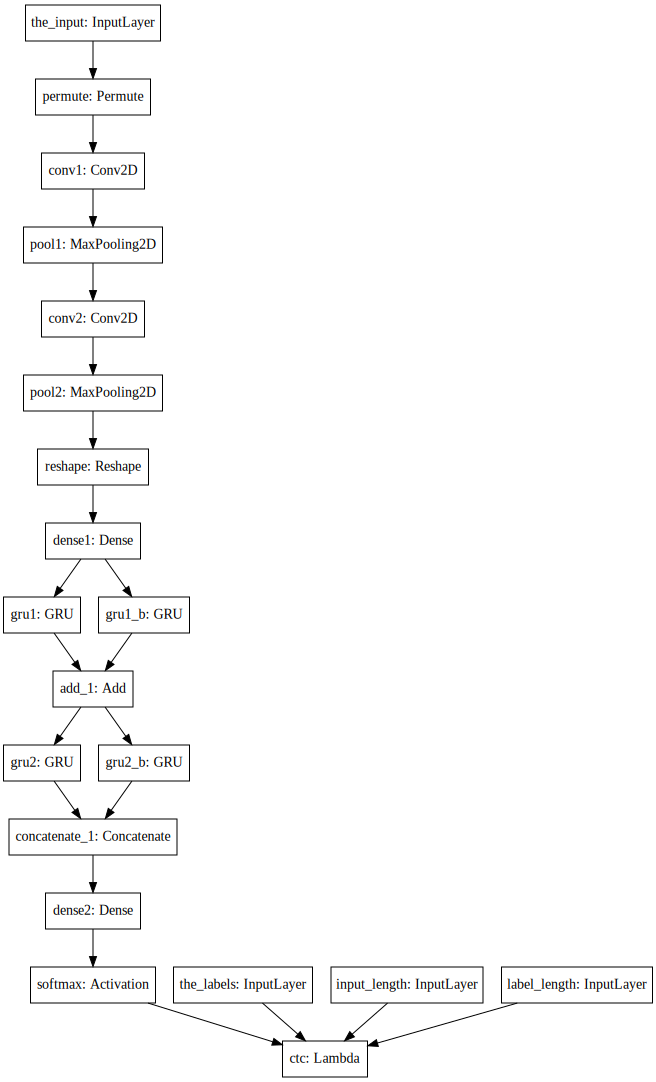

In [11]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG

# TODO: 可视化你的模型
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**


最终使用的是 CNN + RNN网络模型结构，使用ctc_loss计算loss。神经网络包括14层，两个卷积层，两个最大池化层，reshape之后用全连接层连接到GRU网络，重复堆叠两次，最后连接到一个全连接层上，用ctc_lambda计算损失。一共有4,851,083个训练参数。
__________________________________________________________________________________________________

### 练习：训练你的网络模型

训练你的模型时，需要设置训练集和验证集。

In [12]:
# TODO: 训练你的模型
# model.fit(X_train_old, y_train_old, batch_size=100, epochs=25)
history=model.fit_generator(generator=train_data_generator.next_batch(), 
                            steps_per_epoch = 1,#train_data_generator.data_amount, 
                            epochs=1512,
                            validation_data=valid_data_generator.next_batch(),
                            validation_steps= 1,#valid_data_generator.data_amount
                           )

Epoch 1/1512
1/1 [==============================] - 14s 14s/step - loss: 60.9798 - acc: 0.0000e+00 - val_loss: 19.9147 - val_acc: 0.0000e+00
Epoch 2/1512
1/1 [==============================] - 13s 13s/step - loss: 19.5756 - acc: 0.0000e+00 - val_loss: 22.0863 - val_acc: 0.0000e+00
Epoch 3/1512
1/1 [==============================] - 13s 13s/step - loss: 22.7608 - acc: 0.0000e+00 - val_loss: 21.4161 - val_acc: 0.0000e+00
Epoch 4/1512
1/1 [==============================] - 13s 13s/step - loss: 21.2150 - acc: 0.0000e+00 - val_loss: 15.8609 - val_acc: 0.0000e+00
Epoch 5/1512
1/1 [==============================] - 13s 13s/step - loss: 16.2183 - acc: 0.0000e+00 - val_loss: 12.1260 - val_acc: 0.0000e+00
Epoch 6/1512
1/1 [==============================] - 13s 13s/step - loss: 12.4237 - acc: 0.0000e+00 - val_loss: 12.0872 - val_acc: 0.0000e+00
Epoch 7/1512
1/1 [==============================] - 13s 13s/step - loss: 11.8388 - acc: 0.0000e+00 - val_loss: 8.9788 - val_acc: 0.0000e+00
Epoch 8/1512
1

Epoch 62/1512
1/1 [==============================] - 14s 14s/step - loss: 2.3430 - acc: 0.2402 - val_loss: 2.1032 - val_acc: 0.2480
Epoch 63/1512
1/1 [==============================] - 14s 14s/step - loss: 2.0985 - acc: 0.2520 - val_loss: 2.1574 - val_acc: 0.2695
Epoch 64/1512
1/1 [==============================] - 14s 14s/step - loss: 2.0330 - acc: 0.2578 - val_loss: 1.9613 - val_acc: 0.2559
Epoch 65/1512
1/1 [==============================] - 14s 14s/step - loss: 2.1631 - acc: 0.2656 - val_loss: 2.1368 - val_acc: 0.2363
Epoch 66/1512
1/1 [==============================] - 13s 13s/step - loss: 2.0863 - acc: 0.2734 - val_loss: 1.8145 - val_acc: 0.2871
Epoch 67/1512
1/1 [==============================] - 14s 14s/step - loss: 1.9641 - acc: 0.2734 - val_loss: 2.0189 - val_acc: 0.2832
Epoch 68/1512
1/1 [==============================] - 14s 14s/step - loss: 1.8663 - acc: 0.2988 - val_loss: 1.9587 - val_acc: 0.2793
Epoch 69/1512
1/1 [==============================] - 13s 13s/step - loss: 1.

Epoch 124/1512
1/1 [==============================] - 14s 14s/step - loss: 0.8689 - acc: 0.6133 - val_loss: 0.9093 - val_acc: 0.6211
Epoch 125/1512
1/1 [==============================] - 14s 14s/step - loss: 0.7533 - acc: 0.6367 - val_loss: 0.8262 - val_acc: 0.6035
Epoch 126/1512
1/1 [==============================] - 13s 13s/step - loss: 0.6956 - acc: 0.6855 - val_loss: 0.8210 - val_acc: 0.6406
Epoch 127/1512
1/1 [==============================] - 13s 13s/step - loss: 0.8306 - acc: 0.6367 - val_loss: 0.8659 - val_acc: 0.6250
Epoch 128/1512
1/1 [==============================] - 14s 14s/step - loss: 0.7556 - acc: 0.7090 - val_loss: 0.8681 - val_acc: 0.6133
Epoch 129/1512
1/1 [==============================] - 12s 12s/step - loss: 0.6592 - acc: 0.6699 - val_loss: 0.7766 - val_acc: 0.6387
Epoch 130/1512
1/1 [==============================] - 14s 14s/step - loss: 0.6163 - acc: 0.6953 - val_loss: 0.9062 - val_acc: 0.6113
Epoch 131/1512
1/1 [==============================] - 14s 14s/step - 

Epoch 186/1512
1/1 [==============================] - 13s 13s/step - loss: 0.4979 - acc: 0.7520 - val_loss: 0.6406 - val_acc: 0.7344
Epoch 187/1512
1/1 [==============================] - 15s 15s/step - loss: 0.4727 - acc: 0.7676 - val_loss: 0.6587 - val_acc: 0.7109
Epoch 188/1512
1/1 [==============================] - 14s 14s/step - loss: 0.4957 - acc: 0.7715 - val_loss: 0.6479 - val_acc: 0.7461
Epoch 189/1512
1/1 [==============================] - 14s 14s/step - loss: 0.5455 - acc: 0.7402 - val_loss: 0.7657 - val_acc: 0.6914
Epoch 190/1512
1/1 [==============================] - 14s 14s/step - loss: 0.5535 - acc: 0.7246 - val_loss: 0.6609 - val_acc: 0.7422
Epoch 191/1512
1/1 [==============================] - 13s 13s/step - loss: 0.4958 - acc: 0.7754 - val_loss: 0.5520 - val_acc: 0.7676
Epoch 192/1512
1/1 [==============================] - 13s 13s/step - loss: 0.5092 - acc: 0.7812 - val_loss: 0.6217 - val_acc: 0.7441
Epoch 193/1512
1/1 [==============================] - 13s 13s/step - 

Epoch 248/1512
1/1 [==============================] - 14s 14s/step - loss: 0.3460 - acc: 0.8242 - val_loss: 0.4894 - val_acc: 0.7754
Epoch 249/1512
1/1 [==============================] - 14s 14s/step - loss: 0.3823 - acc: 0.8379 - val_loss: 0.4857 - val_acc: 0.7852
Epoch 250/1512
1/1 [==============================] - 13s 13s/step - loss: 0.3676 - acc: 0.8281 - val_loss: 0.5199 - val_acc: 0.7852
Epoch 251/1512
1/1 [==============================] - 14s 14s/step - loss: 0.4411 - acc: 0.7930 - val_loss: 0.4455 - val_acc: 0.7871
Epoch 252/1512
1/1 [==============================] - 14s 14s/step - loss: 0.3767 - acc: 0.8164 - val_loss: 0.5767 - val_acc: 0.7852
Epoch 253/1512
1/1 [==============================] - 15s 15s/step - loss: 0.3306 - acc: 0.8145 - val_loss: 0.4769 - val_acc: 0.8203
Epoch 254/1512
1/1 [==============================] - 13s 13s/step - loss: 0.3379 - acc: 0.8477 - val_loss: 0.6023 - val_acc: 0.7617
Epoch 255/1512
1/1 [==============================] - 13s 13s/step - 

Epoch 310/1512
1/1 [==============================] - 14s 14s/step - loss: 0.2780 - acc: 0.8652 - val_loss: 0.3601 - val_acc: 0.8633
Epoch 311/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2621 - acc: 0.8906 - val_loss: 0.4606 - val_acc: 0.8281
Epoch 312/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2307 - acc: 0.8750 - val_loss: 0.4773 - val_acc: 0.8398
Epoch 313/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2435 - acc: 0.8809 - val_loss: 0.4048 - val_acc: 0.8340
Epoch 314/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2609 - acc: 0.9043 - val_loss: 0.3536 - val_acc: 0.8438
Epoch 315/1512
1/1 [==============================] - 14s 14s/step - loss: 0.2884 - acc: 0.8652 - val_loss: 0.3948 - val_acc: 0.8438
Epoch 316/1512
1/1 [==============================] - 14s 14s/step - loss: 0.2669 - acc: 0.8789 - val_loss: 0.4013 - val_acc: 0.8281
Epoch 317/1512
1/1 [==============================] - 13s 13s/step - 

Epoch 372/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1799 - acc: 0.9121 - val_loss: 0.3004 - val_acc: 0.8691
Epoch 373/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1770 - acc: 0.9121 - val_loss: 0.3430 - val_acc: 0.8652
Epoch 374/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2293 - acc: 0.8867 - val_loss: 0.4518 - val_acc: 0.8398
Epoch 375/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1822 - acc: 0.9121 - val_loss: 0.3097 - val_acc: 0.8574
Epoch 376/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2428 - acc: 0.9082 - val_loss: 0.3232 - val_acc: 0.8691
Epoch 377/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2354 - acc: 0.9043 - val_loss: 0.3791 - val_acc: 0.8418
Epoch 378/1512
1/1 [==============================] - 12s 12s/step - loss: 0.2064 - acc: 0.9023 - val_loss: 0.3467 - val_acc: 0.8418
Epoch 379/1512
1/1 [==============================] - 15s 15s/step - 

Epoch 434/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2009 - acc: 0.8984 - val_loss: 0.3968 - val_acc: 0.8340
Epoch 435/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1791 - acc: 0.9141 - val_loss: 0.3653 - val_acc: 0.8516
Epoch 436/1512
1/1 [==============================] - 13s 13s/step - loss: 0.2009 - acc: 0.8965 - val_loss: 0.3451 - val_acc: 0.8516
Epoch 437/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1849 - acc: 0.9160 - val_loss: 0.3016 - val_acc: 0.8613
Epoch 438/1512
1/1 [==============================] - 14s 14s/step - loss: 0.1507 - acc: 0.9199 - val_loss: 0.3397 - val_acc: 0.8398
Epoch 439/1512
1/1 [==============================] - 15s 15s/step - loss: 0.1915 - acc: 0.9180 - val_loss: 0.3764 - val_acc: 0.8535
Epoch 440/1512
1/1 [==============================] - 13s 13s/step - loss: 0.1981 - acc: 0.9004 - val_loss: 0.4005 - val_acc: 0.8477
Epoch 441/1512
1/1 [==============================] - 13s 13s/step - 

Epoch 497/1512
1/1 [==============================] - 7s 7s/step - loss: 0.2012 - acc: 0.9062 - val_loss: 0.3522 - val_acc: 0.8848
Epoch 498/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1901 - acc: 0.8848 - val_loss: 0.3380 - val_acc: 0.8691
Epoch 499/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1613 - acc: 0.9199 - val_loss: 0.3478 - val_acc: 0.8594
Epoch 500/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1189 - acc: 0.9512 - val_loss: 0.4011 - val_acc: 0.8711
Epoch 501/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1539 - acc: 0.9297 - val_loss: 0.3224 - val_acc: 0.8828
Epoch 502/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1336 - acc: 0.9336 - val_loss: 0.2984 - val_acc: 0.8789
Epoch 503/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1254 - acc: 0.9375 - val_loss: 0.3605 - val_acc: 0.8633
Epoch 504/1512
1/1 [==============================] - 7s 7s/step - loss: 0.2084 - a

Epoch 560/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1526 - acc: 0.9082 - val_loss: 0.3976 - val_acc: 0.8730
Epoch 561/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1083 - acc: 0.9453 - val_loss: 0.2617 - val_acc: 0.8906
Epoch 562/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1264 - acc: 0.9375 - val_loss: 0.3372 - val_acc: 0.8730
Epoch 563/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1728 - acc: 0.9199 - val_loss: 0.3313 - val_acc: 0.8867
Epoch 564/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1678 - acc: 0.9219 - val_loss: 0.4254 - val_acc: 0.8633
Epoch 565/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1314 - acc: 0.9297 - val_loss: 0.3604 - val_acc: 0.8828
Epoch 566/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1856 - acc: 0.9219 - val_loss: 0.3108 - val_acc: 0.8691
Epoch 567/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1339 - a

Epoch 623/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1158 - acc: 0.9355 - val_loss: 0.3612 - val_acc: 0.8594
Epoch 624/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1177 - acc: 0.9531 - val_loss: 0.3552 - val_acc: 0.8848
Epoch 625/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1132 - acc: 0.9473 - val_loss: 0.3618 - val_acc: 0.8691
Epoch 626/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1094 - acc: 0.9492 - val_loss: 0.3126 - val_acc: 0.8828
Epoch 627/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1254 - acc: 0.9355 - val_loss: 0.2892 - val_acc: 0.8809
Epoch 628/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1356 - acc: 0.9453 - val_loss: 0.2747 - val_acc: 0.8945
Epoch 629/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1193 - acc: 0.9453 - val_loss: 0.2981 - val_acc: 0.8750
Epoch 630/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1356 - a

Epoch 686/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1560 - acc: 0.9434 - val_loss: 0.2833 - val_acc: 0.8984
Epoch 687/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1206 - acc: 0.9258 - val_loss: 0.3105 - val_acc: 0.8848
Epoch 688/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1303 - acc: 0.9375 - val_loss: 0.3610 - val_acc: 0.8770
Epoch 689/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1203 - acc: 0.9414 - val_loss: 0.3508 - val_acc: 0.8887
Epoch 690/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1298 - acc: 0.9434 - val_loss: 0.3069 - val_acc: 0.8789
Epoch 691/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1000 - acc: 0.9355 - val_loss: 0.3591 - val_acc: 0.8887
Epoch 692/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1629 - acc: 0.9434 - val_loss: 0.3131 - val_acc: 0.8809
Epoch 693/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1683 - a

Epoch 749/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1107 - acc: 0.9434 - val_loss: 0.3202 - val_acc: 0.8770
Epoch 750/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1038 - acc: 0.9492 - val_loss: 0.3204 - val_acc: 0.8672
Epoch 751/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1156 - acc: 0.9512 - val_loss: 0.3042 - val_acc: 0.8730
Epoch 752/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1012 - acc: 0.9473 - val_loss: 0.2958 - val_acc: 0.9023
Epoch 753/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0851 - acc: 0.9668 - val_loss: 0.2956 - val_acc: 0.9121
Epoch 754/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1400 - acc: 0.9297 - val_loss: 0.3170 - val_acc: 0.9004
Epoch 755/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0989 - acc: 0.9492 - val_loss: 0.3034 - val_acc: 0.9082
Epoch 756/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1292 - a

Epoch 812/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0866 - acc: 0.9512 - val_loss: 0.3356 - val_acc: 0.8730
Epoch 813/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0662 - acc: 0.9668 - val_loss: 0.3477 - val_acc: 0.8711
Epoch 814/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0717 - acc: 0.9570 - val_loss: 0.2083 - val_acc: 0.9316
Epoch 815/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0832 - acc: 0.9629 - val_loss: 0.2322 - val_acc: 0.9023
Epoch 816/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0941 - acc: 0.9551 - val_loss: 0.3795 - val_acc: 0.8770
Epoch 817/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0714 - acc: 0.9609 - val_loss: 0.3172 - val_acc: 0.9160
Epoch 818/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0843 - acc: 0.9551 - val_loss: 0.2197 - val_acc: 0.9141
Epoch 819/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0874 - a

Epoch 875/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1267 - acc: 0.9590 - val_loss: 0.2895 - val_acc: 0.9258
Epoch 876/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0759 - acc: 0.9648 - val_loss: 0.3421 - val_acc: 0.8906
Epoch 877/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0712 - acc: 0.9609 - val_loss: 0.2937 - val_acc: 0.9141
Epoch 878/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0987 - acc: 0.9453 - val_loss: 0.2791 - val_acc: 0.9062
Epoch 879/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0744 - acc: 0.9746 - val_loss: 0.4463 - val_acc: 0.8652
Epoch 880/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1101 - acc: 0.9512 - val_loss: 0.2618 - val_acc: 0.9043
Epoch 881/1512
1/1 [==============================] - 7s 7s/step - loss: 0.1069 - acc: 0.9570 - val_loss: 0.2779 - val_acc: 0.8965
Epoch 882/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0757 - a

Epoch 938/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0682 - acc: 0.9746 - val_loss: 0.3666 - val_acc: 0.9023
Epoch 939/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0515 - acc: 0.9766 - val_loss: 0.1956 - val_acc: 0.9180
Epoch 940/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0655 - acc: 0.9707 - val_loss: 0.2758 - val_acc: 0.9062
Epoch 941/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0776 - acc: 0.9590 - val_loss: 0.2633 - val_acc: 0.9062
Epoch 942/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0720 - acc: 0.9609 - val_loss: 0.3061 - val_acc: 0.9082
Epoch 943/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0620 - acc: 0.9668 - val_loss: 0.3163 - val_acc: 0.8926
Epoch 944/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0569 - acc: 0.9727 - val_loss: 0.2110 - val_acc: 0.9297
Epoch 945/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0737 - a

Epoch 1001/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0612 - acc: 0.9668 - val_loss: 0.2873 - val_acc: 0.9219
Epoch 1002/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0738 - acc: 0.9688 - val_loss: 0.2528 - val_acc: 0.9297
Epoch 1003/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0799 - acc: 0.9648 - val_loss: 0.2312 - val_acc: 0.9277
Epoch 1004/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0934 - acc: 0.9570 - val_loss: 0.2745 - val_acc: 0.9199
Epoch 1005/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0562 - acc: 0.9707 - val_loss: 0.2540 - val_acc: 0.9199
Epoch 1006/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0638 - acc: 0.9688 - val_loss: 0.4021 - val_acc: 0.8867
Epoch 1007/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0693 - acc: 0.9707 - val_loss: 0.2935 - val_acc: 0.9004
Epoch 1008/1512
1/1 [==============================] - 7s 7s/step - loss: 0.

1/1 [==============================] - 7s 7s/step - loss: 0.0451 - acc: 0.9746 - val_loss: 0.2926 - val_acc: 0.9062
Epoch 1064/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0792 - acc: 0.9570 - val_loss: 0.2696 - val_acc: 0.9141
Epoch 1065/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0891 - acc: 0.9570 - val_loss: 0.2942 - val_acc: 0.9062
Epoch 1066/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0707 - acc: 0.9609 - val_loss: 0.3055 - val_acc: 0.9180
Epoch 1067/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0706 - acc: 0.9688 - val_loss: 0.3448 - val_acc: 0.9043
Epoch 1068/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0786 - acc: 0.9688 - val_loss: 0.3689 - val_acc: 0.9043
Epoch 1069/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0873 - acc: 0.9551 - val_loss: 0.2366 - val_acc: 0.9199
Epoch 1070/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0710 - acc: 0.96

Epoch 1126/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0454 - acc: 0.9707 - val_loss: 0.1898 - val_acc: 0.9238
Epoch 1127/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0474 - acc: 0.9844 - val_loss: 0.2364 - val_acc: 0.9102
Epoch 1128/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0659 - acc: 0.9629 - val_loss: 0.2263 - val_acc: 0.9277
Epoch 1129/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0758 - acc: 0.9785 - val_loss: 0.2389 - val_acc: 0.9023
Epoch 1130/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0553 - acc: 0.9746 - val_loss: 0.2262 - val_acc: 0.9414
Epoch 1131/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0677 - acc: 0.9707 - val_loss: 0.2417 - val_acc: 0.9102
Epoch 1132/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0661 - acc: 0.9727 - val_loss: 0.3125 - val_acc: 0.9062
Epoch 1133/1512
1/1 [==============================] - 7s 7s/step - loss: 0.

1/1 [==============================] - 7s 7s/step - loss: 0.0743 - acc: 0.9746 - val_loss: 0.2469 - val_acc: 0.9355
Epoch 1189/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0831 - acc: 0.9590 - val_loss: 0.2547 - val_acc: 0.9160
Epoch 1190/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0494 - acc: 0.9824 - val_loss: 0.2486 - val_acc: 0.9121
Epoch 1191/1512
1/1 [==============================] - 8s 8s/step - loss: 0.0595 - acc: 0.9688 - val_loss: 0.3397 - val_acc: 0.9004
Epoch 1192/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0941 - acc: 0.9570 - val_loss: 0.1958 - val_acc: 0.9258
Epoch 1193/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0594 - acc: 0.9688 - val_loss: 0.2603 - val_acc: 0.9180
Epoch 1194/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0641 - acc: 0.9629 - val_loss: 0.2629 - val_acc: 0.9160
Epoch 1195/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0642 - acc: 0.96

Epoch 1251/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0604 - acc: 0.9668 - val_loss: 0.3105 - val_acc: 0.9141
Epoch 1252/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0390 - acc: 0.9766 - val_loss: 0.1973 - val_acc: 0.9238
Epoch 1253/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0748 - acc: 0.9668 - val_loss: 0.2902 - val_acc: 0.9062
Epoch 1254/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0517 - acc: 0.9746 - val_loss: 0.3425 - val_acc: 0.9141
Epoch 1255/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0538 - acc: 0.9785 - val_loss: 0.2469 - val_acc: 0.9102
Epoch 1256/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0630 - acc: 0.9766 - val_loss: 0.2481 - val_acc: 0.9023
Epoch 1257/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0518 - acc: 0.9785 - val_loss: 0.3101 - val_acc: 0.9023
Epoch 1258/1512
1/1 [==============================] - 7s 7s/step - loss: 0.

1/1 [==============================] - 7s 7s/step - loss: 0.0350 - acc: 0.9824 - val_loss: 0.2914 - val_acc: 0.9121
Epoch 1314/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0527 - acc: 0.9805 - val_loss: 0.1969 - val_acc: 0.9355
Epoch 1315/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0362 - acc: 0.9863 - val_loss: 0.2616 - val_acc: 0.9219
Epoch 1316/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0224 - acc: 0.9902 - val_loss: 0.2641 - val_acc: 0.9238
Epoch 1317/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0405 - acc: 0.9824 - val_loss: 0.3633 - val_acc: 0.9160
Epoch 1318/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0460 - acc: 0.9844 - val_loss: 0.3981 - val_acc: 0.9082
Epoch 1319/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0516 - acc: 0.9785 - val_loss: 0.2146 - val_acc: 0.9180
Epoch 1320/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0276 - acc: 0.98

Epoch 1376/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0209 - acc: 0.9902 - val_loss: 0.2264 - val_acc: 0.9277
Epoch 1377/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0497 - acc: 0.9863 - val_loss: 0.2889 - val_acc: 0.9082
Epoch 1378/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0194 - acc: 0.9902 - val_loss: 0.2534 - val_acc: 0.9258
Epoch 1379/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0292 - acc: 0.9902 - val_loss: 0.2597 - val_acc: 0.9316
Epoch 1380/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0203 - acc: 0.9922 - val_loss: 0.1997 - val_acc: 0.9434
Epoch 1381/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0252 - acc: 0.9941 - val_loss: 0.2374 - val_acc: 0.9258
Epoch 1382/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0292 - acc: 0.9824 - val_loss: 0.3012 - val_acc: 0.9297
Epoch 1383/1512
1/1 [==============================] - 7s 7s/step - loss: 0.

1/1 [==============================] - 7s 7s/step - loss: 0.0346 - acc: 0.9883 - val_loss: 0.2600 - val_acc: 0.9277
Epoch 1439/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0424 - acc: 0.9727 - val_loss: 0.2868 - val_acc: 0.9258
Epoch 1440/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0174 - acc: 0.9902 - val_loss: 0.2735 - val_acc: 0.9082
Epoch 1441/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0342 - acc: 0.9844 - val_loss: 0.2559 - val_acc: 0.9238
Epoch 1442/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0319 - acc: 0.9883 - val_loss: 0.3670 - val_acc: 0.9043
Epoch 1443/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0227 - acc: 0.9902 - val_loss: 0.2765 - val_acc: 0.9316
Epoch 1444/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0385 - acc: 0.9844 - val_loss: 0.2437 - val_acc: 0.9043
Epoch 1445/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0591 - acc: 0.97

Epoch 1501/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0458 - acc: 0.9785 - val_loss: 0.3424 - val_acc: 0.9199
Epoch 1502/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0191 - acc: 0.9902 - val_loss: 0.3194 - val_acc: 0.9062
Epoch 1503/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0352 - acc: 0.9824 - val_loss: 0.2700 - val_acc: 0.9121
Epoch 1504/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0453 - acc: 0.9824 - val_loss: 0.1265 - val_acc: 0.9453
Epoch 1505/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0370 - acc: 0.9785 - val_loss: 0.2526 - val_acc: 0.9199
Epoch 1506/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0393 - acc: 0.9844 - val_loss: 0.3599 - val_acc: 0.9023
Epoch 1507/1512
1/1 [==============================] - 7s 7s/step - loss: 0.0219 - acc: 0.9922 - val_loss: 0.3412 - val_acc: 0.9219
Epoch 1508/1512
1/1 [==============================] - 7s 7s/step - loss: 0.

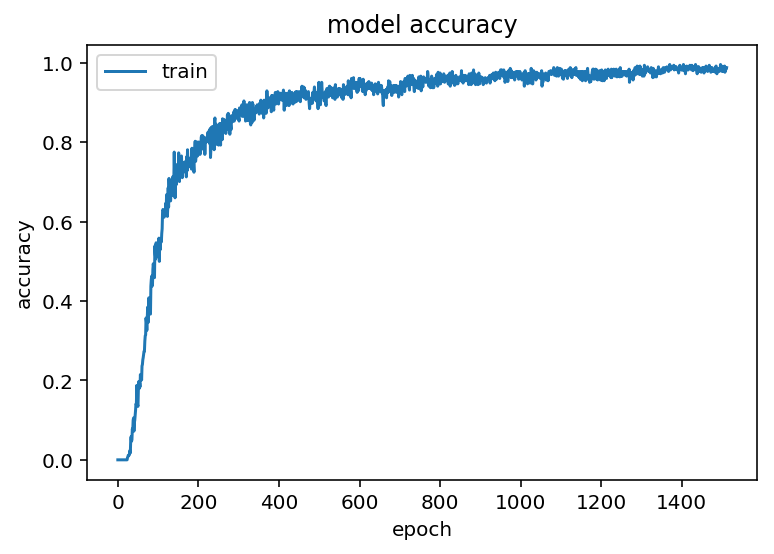

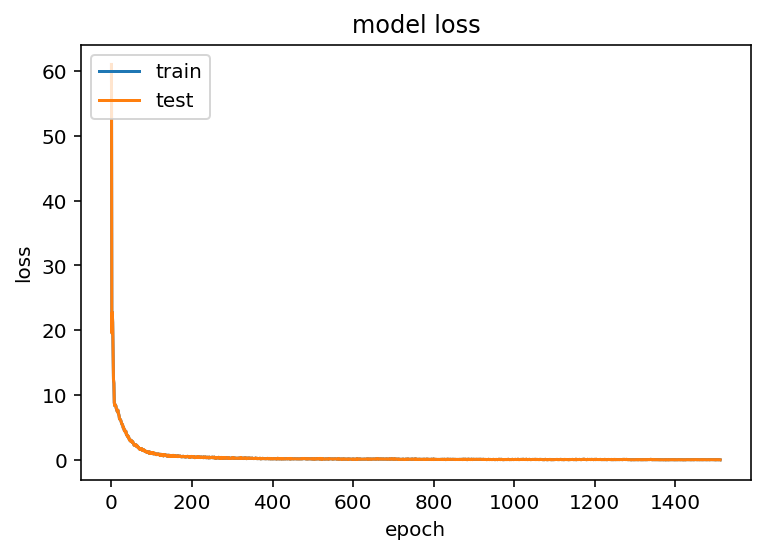

In [13]:
plt.plot()  
plt.plot(history.history['acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [40]:

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                if letters[c] == '#':
                    continue
                outstr += letters[c]
        ret.append(outstr)
    return ret

def decode_data(y_data):
    outstr = ''
    for item in y_data:
        if item != 10:
            outstr += str(int(item))
    return outstr

def decode_data2(y_data):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        if np.argmax(y_data[i]) == 10:
            continue
        resultstr += str(np.argmax(y_data[i]))
    return resultstr
# print model.predict()
# def evaluate(model):
#     # TODO: 按照错一个就算错的规则计算准确率
    
    
# #     print "accuracy: %f" % (float(right_count)/X_test.shape[0])
# #     print wrong_count
# evaluate(model)

In [42]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

test_amount = 0
correct_amount = 0
    
for i in range(len(X_test)):
    test_amount += 1
    x = np.zeros((1, height, width*n_len, 1), dtype=np.uint8)
    x[0, :, :, :] = X_test[i]
    net_out_value = sess.run(net_out, feed_dict={net_inp:x})
    pred_texts = decode_batch(net_out_value)
    
    y_true = decode_data2([y_test[x][i] for x in range(n_len)])
    
    if y_true == pred_texts[0]:
        correct_amount += 1

print "test amount: %d, right answers: %d" % (test_amount, correct_amount)
print "accurrcy: %f" % (float(correct_amount)/test_amount)

test amount: 10000, right answers: 9335
accurrcy: 0.933500


### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**

正确率：93.35%
勉强能解决问题吧，后面尝试增加迭代数，优化训练参数来提升模型性能。

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

In [16]:
def mypredict(x):
    net_out_value = sess.run(net_out, feed_dict={net_inp:x})
    pred_texts = decode_batch(net_out_value)
    return pred_texts

(-0.5, 139.5, 27.5, -0.5)

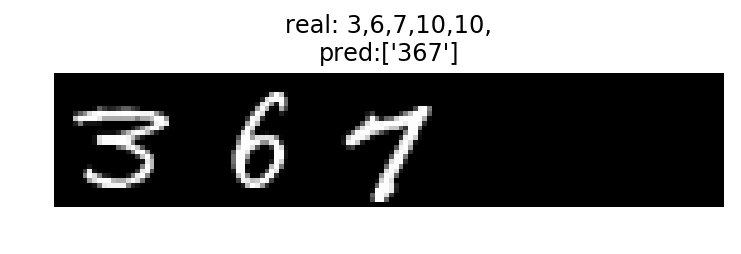

In [17]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
X_data = np.ones([1, height, width*n_len, 1])
X_data[0, :, :, 0] = X_test[index, :, :, 0]
y_pred = mypredict(X_data)
# y_pred = model.predict(X_test[index].reshape(5, height, width, 1))

# plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), y_pred))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要保存模型，以便下次调用。

读取的方式也很简单：`model = load_model('model.h5')`

In [18]:
model.save('model.h5')

In [23]:
a = np.array([1, 3, 2])
print len(a)

3
